# <span style='background-color:#fff5b1'>작성함수
- preprocess()
    - 매개변수로 받은 영상을 모델이 추론할 수 있도록 전처리
    - 전처리
        - resize
            - movenet thunder: 32배수 크기로 resize. 최대 256이되지 않도록 한다.
            - movenet lightning: 32배수 크기로 resize. 최대 192가 되지 않도록 한다.
        - type: int32로 변환한다.
        
- get_model()
    - tensorflow hub에서 Movenet 모델을 다운받아 리턴하는 함수
- draw_keypoints()
    - 모델이 찾은 keypoints(관절)을 원본 이미지 영상에 표시한다.
- draw_edges()
    - keypoint들을 연결하는 것을 원본 이미지에 표시한다.
    
- detect_image()
    - 이미지 영상으로 부터 추론
- detect_video()
    - 동영상으로 부터 추론

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

## 전처리 함수

In [3]:
def preprocess(frame, resize = 256):
    '''
    전처리 함수
    opencv로 읽은 frame을 받아서
    1. BGR => RGB 변환
    2. resize 크기로 이미지를 resize. 종횡비는 유지한다.
    3. int32 타입으로 변환
    4. 배치 axis 추가
    [parameter]
        frame: ndarray - 전처리할 이미지 데이터 (BGR 모드)
        resize: int = 256 - resize 할 이미지 size
    [resize]
        tf.Tensor: 전처리한 이미지 (원본에 대한 복사본을 반환한다.)
    '''
    img = frame.copy()
    # BGR => RGB 변환
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[np.newaxis, ...]
    # resize : thunder - 256 X 256
    img = tf.image.resize_with_pad(img, resize, resize)
    # int32 로 형변환
    img = tf.cast(img, dtype = tf.int32)
    
    return img

In [5]:
v = preprocess(cv2.imread('test_image/babel1.jpg'))
print(type(v), v.shape, v.dtype) # ndarray, (1, 256, 256, 3), int32

<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 256, 256, 3) <dtype: 'int32'>


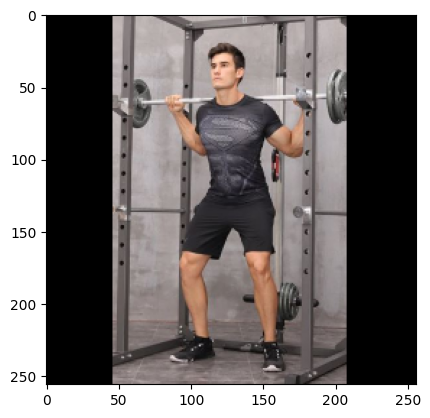

In [6]:
# 함수 확인
import matplotlib.pyplot as plt
plt.imshow(v[0].numpy().astype('uint8'))

## 모델 로딩 함수
- https://tfhub.dev/s?module-type=image-pose-detection

In [7]:
def get_model(version = 'thunder'):
    '''
    Tensorflow Hub에서 Movement 모델을 받아 loading 한뒤 반환.
    [parameter]
        version: str = 'thunder' - 받을 Movement 버전. thunder: 기본값, lightening 들중 어떤 것을 받을지 설정.
    '''
    model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    
    if version == 'lightening':
        model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    
    movenet = model.signatures['serving_default']
    
    return movenet

In [8]:
movenet = get_model()

## keypoint/edge 그리기 함수

In [9]:
EDGE_LINK = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (0, 5),
    (0, 6),
    (5, 7),
    (7, 9),
    (6, 8),
    (8, 10),
    (5, 6),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16)
]

In [10]:
def draw_keypoints(frame, pred, score_threshold=0.3):
    """
    이미지에 모델이 추론한 keypoint들의 위치를 점으로 표시하는 함수.
    [parameter]
        frame: ndarray - keypoint들을 그릴 이미지. (원본 크기의 width/height 동일하게 resize한 이미지-종횡비유지)
        pred: dictionary - Movenet 모델이 추론한 추론결과. 
        score_threshold: float - 표시할 keypoint들의 confidence score 임계값. 지정한 값 이상이 것들만 표시.
    [return]
        tuple: (ndarray: keypoint들을 표시한 이미지,  ndarray: denormalized한 keypoint좌표+confidence score)
    """
    height, width, _ = frame.shape
    keypoints = pred['output_0']
    
    denorm_keypoints = np.squeeze(np.multiply(keypoints, [height, width, 1]))
    for kp_y, kp_x, kp_score in denorm_keypoints:
        if kp_score > score_threshold:
            cv2.circle(img=frame, 
                       center=(int(kp_x), int(kp_y)), 
                       radius=3, thickness=-1,
                       color=[255, 255, 0], lineType=cv2.LINE_AA)
    return frame, denorm_keypoints

In [11]:
def draw_edge(frame, denormalized_keypoints, score_threshold=0.1):
    """
    이미지에 keypoint들을 연결하는 Edge를 표시하는 함수.
    [parameter]
        frame: ndarray - edge를 그릴 이미지. 
        denormalized_keypoints: ndarray - 모델이 추청한 normaized된 keypoint들 이미지의 width/height 크기에 맞춰 
                                          denormalize 한 keypoint 값들 + confidence score
        score_threshold: float - 표시할 keypoint들의 confidence score 임계값. 지정한 값 이상이 것들만 표시.
    [return]
        ndarray: edge를 표시한 이미지.
    """
    for edge in EDGE_LINK:  # (0, 1)  `0:코` 와 `1:왼쪽눈` 을 연결
        p1, p2 = edge     
        y1, x1, score1 = denormalized_keypoints[p1]
        y2, x2, score2 = denormalized_keypoints[p2]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        if score1 >= score_threshold and score2 >= score_threshold:
             cv2.line(img=frame, 
                              pt1=(x1, y1), 
                              pt2=(x2, y2), 
                              color=[0, 255, 255], thickness=1, lineType=cv2.LINE_AA
                             )
    return frame

## 추론함수

In [12]:
def detect_image(img_path, movenet):
    """
    이미지 경로와 모델을 받아서 추론 후 결과이미지를 출력하는 함수.
    """

    image = cv2.imread(img_path)

    input_tensor = preprocess(image, resize=256)

    pred = movenet(input_tensor)
    
    height, width, _ = image.shape
    height = width = max(height, width)
    image = tf.image.resize_with_pad(image, height, width)
    image = image.numpy().astype('uint8')
    
    
    result_frame_temp, denorm_keypoints =  draw_keypoints(image, pred)
    
    result_frame = draw_edge(result_frame_temp, denorm_keypoints)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
    plt.show()

2023-03-23 19:03:13.828404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


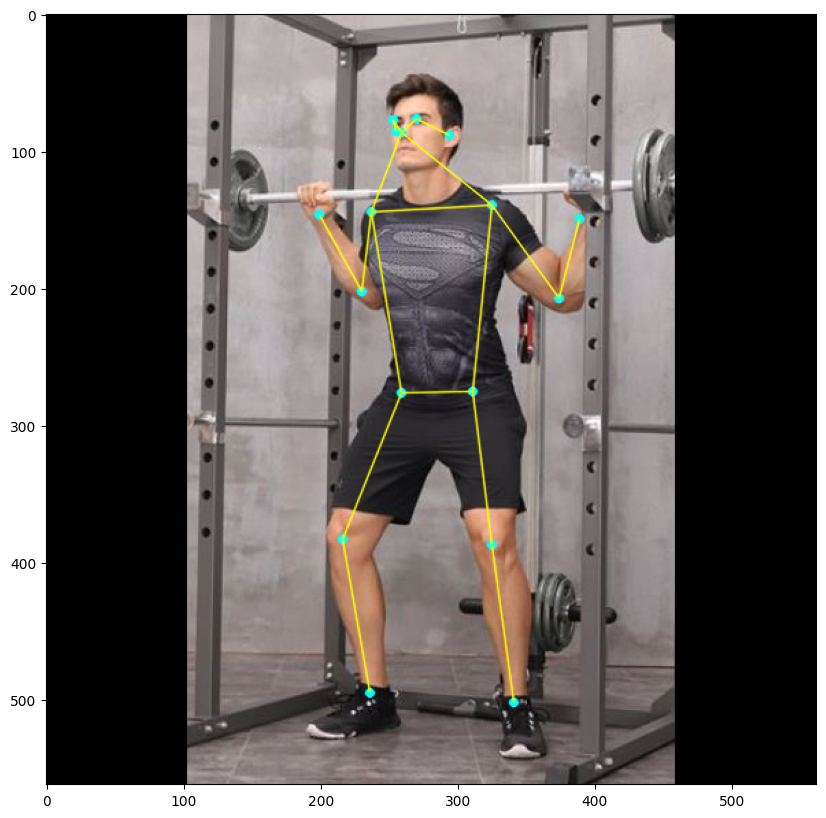

In [14]:
img_path = 'test_image/babel1.jpg'
movenet = get_model()

detect_image(img_path, movenet)

In [15]:
def detect_webcam(movenet, resize=256):
    # 웹캠으로 실시간 detection 처리
    
    cap = cv2.VideoCapture(1)
    while True:
        
        succ, frame = cap.read()
        if not succ:
            print('캡쳐실패')
            break
        frame = cv2.flip(frame, 1)
        # 전처리
        input_tensor = preprocess(frame, resize)
        # 추론
        pred = movenet(input_tensor)
        # 추론결과를 원본 이미지에 그리기
        height, width, _ = frame.shape
        height = width = max(height, width)
        frame = tf.image.resize_with_pad(frame, height, width).numpy().astype('uint8')
        # keypoints 점 그리기
        result_frame_temp, denorm_kp = draw_keypoints(frame, pred)
        # edge 그리기
        result = draw_edge(result_frame_temp, denorm_kp)
        
        cv2.imshow('frame', result)
        if cv2.waitKey(1) == 27:
            break
            
    cap.release()
    cv2.waitKey()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [17]:
detect_webcam(movenet)